[View in Colaboratory](https://colab.research.google.com/github/farhanhubble/airbus-shipspotting/blob/master/airbus.ipynb)

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
!ls /content/gdrive/My\ Drive/Colab\ Notebooks

airbus.ipynb					       Untitled0.ipynb
Copy of Linear Regression A Tale of a Transform.ipynb  Untitled1.ipynb
train_ship_segmentations.csv			       Untitled2.ipynb
Untitled					       Untitled3.ipynb


In [0]:
import pandas as pd

In [0]:
train_segments = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/train_ship_segmentations.csv')

In [18]:
train_segments.shape

NameError: ignored

In [39]:
train_segments.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


In [9]:
import numpy as np
if np.isnan(float('nan')):
  print('Hello')

Hello


In [0]:
def RLE2image(rle, img_height:int,img_width:int):
  mask = np.zeros(img_height * img_width, dtype=np.int)
  
  def reshape_mask():
    return mask.reshape((img_height, img_width)).T
  
  if isinstance(rle,float) and np.isnan(rle):
    return reshape_mask()
  
  else:
    # Split the data
    splitted_rle = rle.split(' ')
    
    for i in range(0, len(splitted_rle), 2):
      start = int(splitted_rle[i])
      end = int(splitted_rle[i+1])
      
      mask[start:start+end] = 1
      
  return reshape_mask()
      

In [0]:
masks = RLE2image(train_segments.EncodedPixels[1], 768, 768)

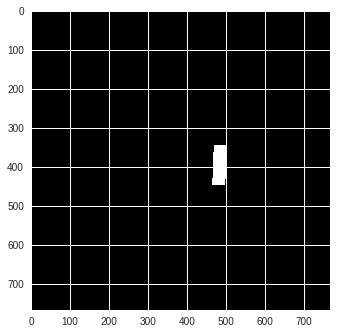

In [49]:
plt.imshow(masks, cmap='gray')
plt.show()

In [0]:
import keras as ks

In [42]:
from keras.layers import Input, Conv2D, MaxPool2D, Conv2DTranspose, Concatenate

inputs = Input(shape=(768,768,3))
#reshape_inputs = Reshape((572, 572, 3))(inputs)


# Add first convolution layer [768,768, 3]
conv_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(inputs)
# Add second convolution layer [766,766, 64]
conv_2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(conv_1)
# Add first max pool layer [764,764, 64]
maxpool_1 = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid')(conv_2)

# Add third convolution layer [382,382, 64]
conv_3 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(maxpool_1)
# Add fourth convolution layer [380,380, 128]
conv_4 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(conv_3)
# Add the second max pool layer [378, 378, 128]
maxpool_2 = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid')(conv_4)


# Add fifth convolution layer [189,189, 128]
conv_5 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(maxpool_2)
# Add sixth convolution layer [187,187, 256]
conv_6 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(conv_5)
# Add the third max pool layer [185, 185, 256]
maxpool_3 = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid')(conv_6)

# Add seventh convolution layer [92,92, 256]
conv_7 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(maxpool_3)
# Add eighth convolution layer [90, 90, 512]
conv_8 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(conv_7)
# Add thr fourth max pool layer [88, 88, 512]
maxpool_4 = MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid')(conv_8)


# Add ninth convolution layer [44,44, 512]
conv_9 = Conv2D(filters=1024, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(maxpool_4)
# Add tenth convolution layer [42, 42, 1024]
conv_10 = Conv2D(filters=1024, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(conv_9)



# Start with adding deconvolution layers[42, 42, 1024]
deconv_1 = Conv2DTranspose(filters=512,kernel_size=(2,2), strides=(1,1), padding='valid', activation='relu')(conv_10) # [84, 84, 512]
# Take the output of conv_8 layer[88, 88, 512] and combine it with deconv_1 [84, 84, 512]
combine_1 = Concatenate(axis=3, [deconv_1, conv_8[2:-2, 2:-2, :]]) #[84, 84, 1024]

# Add eleventh convolution layer [84, 84, 1024]
conv_11 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(combine_1) #[82,82,512]
# Add twelveth convolution layer [82, 82, 512]
conv_12 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(conv_11) #[80,80,256]

# Add the second deconvolution layer [80, 80, 256]
deconv_2 = Conv2DTranspose(filters=256,kernel_size=(2,2), strides=(1,1), padding='valid', activation='relu')(conv_12) # [160, 160, 256]
# Take the output of conv_6 layer[185, 185, 256] and combine it with deconv_2 [160, 160, 256]
combine_2 = Concatenate(axis=3, [deconv_2, conv_6[13:-12, 13:-12, :]]) #[160, 160, 512]


# Add thirteenth convolution layer [160, 160, 512]
conv_13 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(combine_2) #[158,158,256]
# Add fourteenth convolution layer [158, 158, 256]
conv_14 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(conv_13) #[156,156,128]



# Add the third deconvolution layer [156,156, 128]
deconv_3 = Conv2DTranspose(filters=128,kernel_size=(2,2), strides=(1,1), padding='valid', activation='relu')(conv_14) # [312, 312, 128]
# Take the output of conv_4 layer[378, 378, 128] and combine it with deconv_3 [312, 312, 128]
combine_3 = Concatenate(axis=3, [deconv_3, conv_4[32:-32, 32:-32, :]]) #[312, 312, 256]


# Add fifteenth convolution layer[312, 312, 256]
conv_15 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(combine_3) #[310,310,128]
# Add sixteenth convolution layer [310, 310, 128]
conv_16 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(conv_15) #[308,308,64]


# Add the fourth deconvolution layer [308,308, 64]
deconv_4 = Conv2DTranspose(filters=64,kernel_size=(2,2), strides=(1,1), padding='valid', activation='relu')(conv_16) # [616, 316, 64]
# Take the output of conv_2 layer[764, 764, 64] and combine it with deconv_4 [616, 616, 64]
combine_3 = Concatenate(axis=3, [deconv_4, conv_2[74:-74, 74:-74, :]]) #[616, 616, 128]


SyntaxError: ignored

In [0]:
Concatenate?

In [0]:
from PIL import Image

In [0]:
test_image = Image.open('/content/gdrive/My Drive/Colab Notebooks/ffd9998b5.jpg')

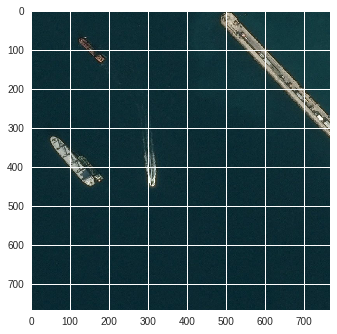

In [56]:
plt.imshow(test_image)
plt.show()

In [0]:
test_mask_rle = train_segments.EncodedPixels[train_segments.ImageId == 'ffd9998b5.jpg']

In [75]:
test_mask_rle

130964    91469 1 92236 3 93003 5 93770 7 94537 9 95304 ...
130965    91003 1 91770 3 92537 5 93304 7 94071 9 94839 ...
130966    237754 7 238522 13 239290 13 240057 14 240825 ...
130967    31822 1 32589 3 33356 5 34123 8 34891 9 35658 ...
Name: EncodedPixels, dtype: object

In [71]:
test_mask_rle[130964]

'91469 1 92236 3 93003 5 93770 7 94537 9 95304 11 96071 13 96838 15 97605 17 98372 19 99139 21 99908 21 100677 21 101446 21 102215 21 102984 20 103753 20 104522 20 105291 20 106060 20 106829 20 107598 20 108367 20 109136 20 109905 20 110673 21 111442 21 112211 21 112980 21 113749 21 114518 21 115287 21 116056 21 116825 21 117594 21 118363 21 119132 21 119901 21 120670 21 121439 21 122208 21 122977 21 123746 21 124515 21 125284 21 126053 20 126822 20 127591 20 128360 20 129129 20 129898 20 130667 20 131436 20 132205 20 132974 20 133742 21 134511 21 135280 21 136049 21 136818 21 137587 21 138356 19 139125 17 139894 15 140663 13 141432 11 142201 9 142970 7 143739 5 144508 3 145277 1'

In [0]:
test_massk = RLE2image(test_mask_rle[130964], 768, 768)

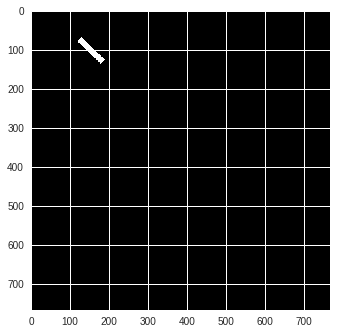

In [80]:
plt.imshow(test_massk, cmap='gray')
plt.show()

In [83]:
type(test_massk)

numpy.ndarray